In [32]:
import tensorflow as tf
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [33]:
url = 'https://storage.googleapis.com/bucketsformodel/embedding.csv'
data = pd.read_csv(url)

In [34]:
TRAINING_SIZE = 20000
VOCAB_SIZE = 50000
MAX_LENGTH = 128
EMBEDDING_DIM = 16

In [35]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [36]:
# from nltk.corpus import stopwords
# import nltk

# # Pastikan resource NLTK terunduh
# nltk.download('punkt')  # Tokenizer
# nltk.download('stopwords')  # Stopwords
# nltk.download('punkt_tab')

# def preprocess_text(text):
#     """Membersihkan teks: huruf kecil, hapus stopwords."""
#     text = text.lower()
#     words = nltk.word_tokenize(text)  # Tokenizer dari 'punkt'
#     stop_words = set(stopwords.words('indonesian'))  # Stopwords bahasa Indonesia
#     words = [word for word in words if word not in stop_words]  # Hapus stopwords
#     return " ".join(words)

# # Terapkan preprocessing pada kolom 'Deskripsi'
# data['Deskripsi'] = data['Deskripsi'].astype(str).apply(preprocess_text)


In [37]:
rare_categories = data['Kategori'].value_counts()[data['Kategori'].value_counts() <= 2].index.tolist()
common_data = data[~data['Kategori'].isin(rare_categories)]
rare_data = data[data['Kategori'].isin(rare_categories)]

In [38]:
# Memisahkan kategori langka (rare) dan umum
rare_categories = data['Kategori'].value_counts()[data['Kategori'].value_counts() <= 2].index.tolist()

# Data dengan kategori umum
common_data = data[~data['Kategori'].isin(rare_categories)]

# Data dengan kategori langka
rare_data = data[data['Kategori'].isin(rare_categories)]

# Stratified split untuk data dengan kategori umum
train_common, test_common = train_test_split(
    common_data,
    test_size=0.2,
    stratify=common_data['Kategori'],
    random_state=42
)

# Gabungkan data kategori langka ke train (agar tetap ada dalam model)
train_data = pd.concat([train_common, rare_data], ignore_index=True)

# Test data tetap hanya dari kategori umum
test_data = test_common

# Hasil
print("Jumlah data Train:", len(train_data))
print("Jumlah data Test:", len(test_data))
print("\nDistribusi data Train:")
print(train_data['Kategori'].value_counts())
print("\nDistribusi data Test:")
print(test_data['Kategori'].value_counts())

Jumlah data Train: 53
Jumlah data Test: 13

Distribusi data Train:
Kategori
Nature & Adventure & Park    27
Historical & Museum          14
Waterpark                     6
Food                          5
Zoo                           1
Name: count, dtype: int64

Distribusi data Test:
Kategori
Nature & Adventure & Park    7
Historical & Museum          3
Food                         2
Waterpark                    1
Name: count, dtype: int64


In [39]:
encoder = OneHotEncoder()
train_labels = encoder.fit_transform(train_data[['Kategori']]).toarray()
test_labels = encoder.transform(test_data[['Kategori']]).toarray()

In [40]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_data['Deskripsi'])

In [41]:
train_sequences = tokenizer.texts_to_sequences(train_data['Deskripsi'])
test_sequences = tokenizer.texts_to_sequences(test_data['Deskripsi'])

# Padding sequence
train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post')

In [42]:
train_dataset_tf = tf.data.Dataset.from_tensor_slices((train_padded, train_labels))
test_dataset_tf = tf.data.Dataset.from_tensor_slices((test_padded, test_labels))

In [43]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_dataset_tf = (train_dataset_tf
                    .shuffle(SHUFFLE_BUFFER_SIZE)
                    .batch(BATCH_SIZE)
                    .prefetch(tf.data.AUTOTUNE))
test_dataset_tf = (test_dataset_tf
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.AUTOTUNE))

In [44]:
vocabulary = tokenizer.word_index
print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 990


In [45]:
print(train_sequences)

[[37, 308, 11, 37, 524, 118, 309, 1, 13, 16, 310, 5, 26, 311, 312, 89, 3, 67, 77, 37, 4, 90, 47, 119, 1, 313, 167, 15, 216, 14, 47, 525, 2, 47, 526, 19, 168, 37, 308, 217, 30, 218, 142, 37, 37, 314, 14, 527, 528, 2, 529, 530, 531, 1, 143, 3, 219, 47, 119, 17, 91, 78, 103, 104, 315, 37, 4], [316, 317, 120, 11, 91, 78, 35, 21, 18, 68, 3, 59, 1, 13, 32, 60, 43, 6, 38, 7, 4, 90, 79, 220, 5, 105, 532, 533, 61, 6, 44, 44, 221, 534, 20, 52, 222, 60, 318, 18, 2, 79, 319, 1, 106, 48, 14, 223, 224, 225, 2, 39, 80, 81, 320, 226, 121, 316, 317, 120, 12, 53, 535, 169, 227, 14, 536, 220, 22, 92, 537, 1, 43, 15, 33], [24, 62, 228, 69, 122, 23, 1, 538, 107, 123, 144, 539, 540, 541, 5, 321, 1, 542, 543, 322, 323, 93, 324, 123, 144, 3, 170, 45, 544, 545, 9, 171, 94, 325, 123, 546, 547, 548, 1, 95, 2, 549, 1, 550, 551, 45, 81, 9, 552, 20, 52, 27, 145, 1, 229, 2, 230, 326, 45, 81, 9, 327, 14, 328, 553, 96, 172, 554, 231, 329, 330, 6, 173, 123, 144, 232, 4], [555, 5, 556, 24, 62, 49, 54, 1, 40, 331, 332, 1

In [46]:
print(test_sequences)

[[24, 855, 856, 19, 41, 98, 199, 738, 11, 233, 5, 177, 203, 2, 26, 10, 1, 57, 13, 16, 573, 5, 10, 293, 49, 278, 3, 77, 199, 753, 1, 358, 451, 3, 427, 230, 22, 155, 65, 3, 378, 124, 31, 8, 18, 15, 136, 54, 11, 274, 966, 1, 384, 190], [863, 9, 864, 29, 51, 130, 3, 2, 3, 793, 18, 52, 29, 5, 66, 393, 2, 11, 108, 1, 99, 36, 130, 20, 17, 274, 15, 51, 204, 12, 13, 16, 73, 1, 50, 45, 9, 965, 3, 7, 314, 107, 25, 1, 99, 32, 22, 293, 583, 19, 11, 35, 21, 1, 61, 6, 127, 406, 9, 305, 221, 369, 1, 24, 226, 36, 130, 231, 329, 330, 6, 438, 7, 232, 4], [75, 1, 89, 118, 138, 19, 75, 408, 11, 279, 521, 314, 3, 403, 37, 42, 75, 4, 90, 770, 73, 514, 973, 1, 703, 56, 163, 67, 118, 75, 408, 2, 75, 90, 103, 104, 347, 154, 75, 4, 461, 966, 3, 87, 199, 281, 33, 30, 8, 27, 1, 112, 2, 459, 131, 75, 4, 53, 190, 140, 19, 36, 2, 56, 3, 403, 701, 37, 42], [18, 295, 1, 970, 140, 274, 1, 11, 35, 10, 3, 450, 59, 453, 519, 357, 1, 358, 2, 177, 137, 74, 18, 295, 4, 374, 27, 1, 977, 47, 460, 18, 295, 30, 5, 605, 359, 975, 

In [47]:
# Vectorize Text Data
vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_LENGTH
)

In [48]:
# Fit vectorizer on training data
vectorize_layer.adapt(train_data['Deskripsi'])

In [49]:
# Vectorize text data
X_train_vectorized = vectorize_layer(train_data['Deskripsi'])
X_test_vectorized = vectorize_layer(test_data['Deskripsi'])

In [50]:
# Encode the labels to integers
label_encoder = {label: idx for idx, label in enumerate(data['Kategori'].unique())}
train_data['Kategori_encoded'] = train_data['Kategori'].map(label_encoder)
test_data['Kategori_encoded'] = test_data['Kategori'].map(label_encoder)

In [51]:
# Convert labels to one-hot encoding
num_classes = len(label_encoder)
y_train_onehot = to_categorical(train_data['Kategori_encoded'], num_classes)
y_test_onehot = to_categorical(test_data['Kategori_encoded'], num_classes)

In [61]:
# Define the Model
model = models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH),
    layers.GlobalAveragePooling1D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [62]:
# Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [63]:
# Train the Model
history = model.fit(
    X_train_vectorized, y_train_onehot,
    validation_data=(X_test_vectorized, y_test_onehot),
    epochs=100,
    batch_size=32
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.1319 - loss: 1.6125 - val_accuracy: 0.5385 - val_loss: 1.6034
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5063 - loss: 1.6031 - val_accuracy: 0.5385 - val_loss: 1.5953
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5063 - loss: 1.5945 - val_accuracy: 0.5385 - val_loss: 1.5844
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4855 - loss: 1.5847 - val_accuracy: 0.5385 - val_loss: 1.5699
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5271 - loss: 1.5663 - val_accuracy: 0.5385 - val_loss: 1.5499
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5167 - loss: 1.5508 - val_accuracy: 0.5385 - val_loss: 1.5237
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5480 - loss: 1.5130 - val_accuracy: 0.5385 - val_loss: 1.4891
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5063 - loss: 1.4903 - val_accuracy: 0.5385 - val_loss

In [64]:
# Evaluasi Model
loss, accuracy = model.evaluate(X_test_vectorized, y_test_onehot)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9231 - loss: 0.2203
Test Loss: 0.2203
Test Accuracy: 0.9231


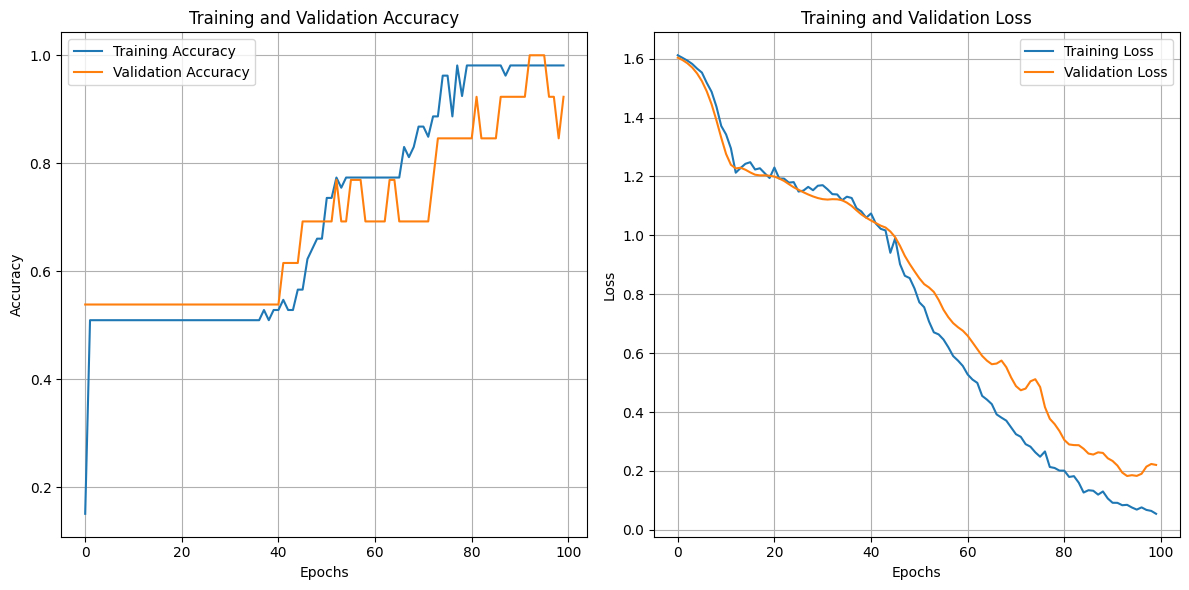

In [65]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [66]:
# Prediksi Probabilitas
predictions_prob = model.predict(X_test_vectorized)

# Prediksi Label (kategori dengan probabilitas tertinggi)
predictions = predictions_prob.argmax(axis=1)

# Map kembali label angka ke nama kategori
decoded_predictions = [list(label_encoder.keys())[list(label_encoder.values()).index(pred)] for pred in predictions]

# Contoh 5 prediksi pertama
for i in range(5):
    print(f"Teks: {test_data['Deskripsi'].iloc[i]}")  # Ambil dari test_data['Deskripsi']
    print(f"Kategori Prediksi: {decoded_predictions[i]}")
    print(f"Kategori Sebenarnya: {list(label_encoder.keys())[list(label_encoder.values()).index(test_data['Kategori_encoded'].iloc[i])]}")
    print()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Teks: Ingin melarikan diri sejenak dari hiruk pikuk kota? Taman Hutan Rakyat adalah jawabannya! Dengan udara segar dan pemandangan alam yang hijau sejauh mata memandang, Tahura menawarkan pengalaman mendalam dengan alam. Nikmati sensasi trekking di tengah hutan pinus yang rindang, berkemah di bawah langit penuh bintang, atau sekadar bersantai di tepi sungai sambil menikmati suara gemericik air. Bagi pecinta petualangan, Tahura adalah surga tersembunyi yang wajib dikunjungi.
Kategori Prediksi: Nature & Adventure & Park
Kategori Sebenarnya: Nature & Adventure & Park

Teks: Pernahkah Anda membayangkan bisa mendengar suara asli para legenda musik Indonesia? Di Lokananta, studio rekaman pertama dan terbesar di tanah air, mimpi itu bisa jadi kenyataan! Dengan koleksi ribuan piringan hitam dan master rekaman asli, Lokananta adalah kapsul waktu yang menyimpan sejarah musik Indonesia. Selain menjadi surga bagi para pencinta musik, Lokananta juga menawarkan 

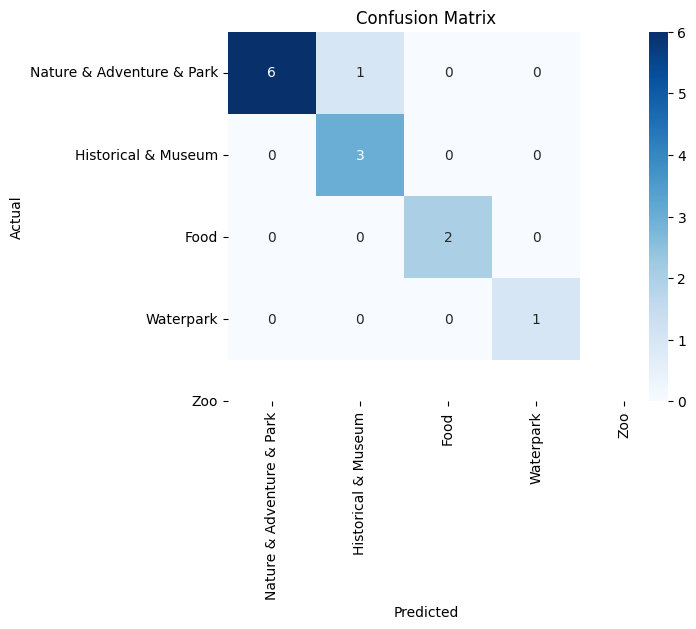

                           precision    recall  f1-score   support

Nature & Adventure & Park       1.00      0.86      0.92         7
      Historical & Museum       0.75      1.00      0.86         3
                     Food       1.00      1.00      1.00         2
                Waterpark       1.00      1.00      1.00         1

                 accuracy                           0.92        13
                macro avg       0.94      0.96      0.95        13
             weighted avg       0.94      0.92      0.93        13



In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Konversi label sebenarnya dari one-hot encoding ke bentuk asli
y_test_actual = test_data['Kategori_encoded'].values  # Ambil dari test_data

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_actual, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.keys(), yticklabels=label_encoder.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Ambil hanya kategori yang muncul dalam data uji
present_labels = sorted(set(y_test_actual))  # Label yang ada di y_test_actual
present_target_names = [list(label_encoder.keys())[list(label_encoder.values()).index(label)] for label in present_labels]

# Classification Report
report = classification_report(y_test_actual, predictions, labels=present_labels, target_names=present_target_names)
print(report)



In [59]:
# # Data Baru
# new_texts = ["kuliner khas Solo"]
# new_texts_vectorized = vectorize_layer(new_texts)

# # Prediksi
# new_predictions_prob = model.predict(new_texts_vectorized)
# new_predictions = new_predictions_prob.argmax(axis=1)
# new_decoded_predictions = [list(label_encoder.keys())[list(label_encoder.values()).index(pred)] for pred in new_predictions]

# print(f"Prediksi untuk teks baru: {new_decoded_predictions}")


In [70]:
# Simpan model
model.save("recommender.h5")

# # Muat model
# loaded_model = tf.keras.models.load_model("text_classification_modelnew.h5")

# # Gunakan untuk prediksi
# loaded_predictions = loaded_model.predict(new_texts_vectorized)
